# Mouse 7 Analysis

This notebook loads mouse7 data, 
- plots max projection with GT and predicted masks, 
- visualizes ROI area distributions,
- compute and visualize ROIs shape 



In [2]:
# --- Imports and configuration ---
import os, sys, glob, re
import numpy as np
import h5py
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.sparse import csc_matrix

REPO_ROOT = '/gpfs/home/bizzin01/nicole/code/SUNS_nicole'
if REPO_ROOT not in sys.path:
    sys.path.insert(0, REPO_ROOT)

from suns.PreProcessing.preprocessing_functions import find_dataset

# Dataset selection
active_set = 'mouse7_suite2pGT'
exp_id = 'mouse7_773'

# Paths for this dataset
from suns import config as suns_config
list_Exp_ID = suns_config.EXP_ID_SETS[active_set]
dir_video = suns_config.DATAFOLDER_SETS[active_set]
dir_parent = os.path.join(dir_video, 'output_mouse7_suite2pGT')
dir_net_in = os.path.join(dir_parent, 'network_input')
weights_path = os.path.join(dir_parent, 'Weights')
dir_output = os.path.join(dir_parent, 'output_masks')

print('dir_video:', dir_video)
print('dir_parent:', dir_parent)
print('dir_output:', dir_output)


dir_video: /gpfs/home/bizzin01/nicole/code/SUNS_nicole/demo/mouse7_suite2pGT
dir_parent: /gpfs/home/bizzin01/nicole/code/SUNS_nicole/demo/mouse7_suite2pGT/output_mouse7_suite2pGT
dir_output: /gpfs/home/bizzin01/nicole/code/SUNS_nicole/demo/mouse7_suite2pGT/output_mouse7_suite2pGT/output_masks


In [3]:
# --- Helper functions ---
from typing import Tuple

def compute_max_projection_from_h5(h5_path: str) -> np.ndarray:
    with h5py.File(h5_path, 'r') as f:
        dset_name = find_dataset(f)
        dset = f[dset_name]
        nframes = dset.shape[0]
        max_img = np.array(dset[0], dtype=np.float32)
        for i in range(1, nframes):
            np.maximum(max_img, dset[i], out=max_img)
    vmin, vmax = float(max_img.min()), float(max_img.max())
    if vmax > vmin:
        max_img = (max_img - vmin) / (vmax - vmin)
    else:
        max_img = np.zeros_like(max_img, dtype=np.float32)
    return max_img


def load_gt_sparse_masks(gt_sparse_path: str, dims: Tuple[int, int]) -> np.ndarray:
    Lx, Ly = dims
    md = loadmat(gt_sparse_path)
    GT = csc_matrix(md['GTMasks_2'])
    pixels = Lx * Ly
    if GT.shape[0] == pixels and GT.shape[1] != pixels:
        GTp = GT
        
    elif GT.shape[1] == pixels and GT.shape[0] != pixels:
        GTp = GT.transpose()
    else:
        GTp = GT
    n_gt = GTp.shape[1]
    masks = np.zeros((n_gt, Lx, Ly), dtype=bool)
    for j in range(n_gt):
        idx = GTp.getcol(j).indices
        masks[j].ravel()[idx] = True
    return masks


def load_gt_dense_masks(dense_path: str) -> np.ndarray:
    """Load dense GT FinalMasks from MAT (handles v7.3 HDF5 and v7).
    Returns (n, Lx, Ly) bool, or empty (0, Lx, Ly) if not found.
    """
    if not os.path.exists(dense_path):
        return np.zeros((0, 0, 0), dtype=bool)
    # Try HDF5 (-v7.3)
    try:
        with h5py.File(dense_path, 'r') as f:
            if 'FinalMasks' in f:
                arr = np.array(f['FinalMasks'])  # (Ly, Lx, n)
                if arr.ndim == 3:
                    return np.transpose(arr, (2, 1, 0)).astype(bool)  # -> (n, Lx, Ly)
    except OSError:
        pass
    # Fallback to MATLAB v7
    try:
        md = loadmat(dense_path)
        arr = md.get('FinalMasks')
        if arr is None:
            return np.zeros((0, 0, 0), dtype=bool)
        arr = np.array(arr)
        if arr.ndim == 3:
            return np.transpose(arr, (2, 1, 0)).astype(bool)  # -> (n, Lx, Ly)
    except Exception:
        return np.zeros((0, 0, 0), dtype=bool)
    return np.zeros((0, 0, 0), dtype=bool)


def load_pred_masks_from_mat(out_mat_path: str, dims: Tuple[int, int]) -> np.ndarray:
    Lx, Ly = dims
    md = loadmat(out_mat_path)
    m = md.get('Masks')
    if m is None:
        raise RuntimeError("'Masks' not found in output mat")
    # stored as (Lx, Ly, n)
    masks = np.transpose(m.astype(bool), (2, 0, 1))
    return masks


def pad_masks_top_left(masks: np.ndarray, target_dims: Tuple[int, int]) -> np.ndarray:
    """Pad masks (N, Lx_src, Ly_src) into top-left of a (N, Lx_tgt, Ly_tgt) canvas.
    If masks already match target size, returns as-is.
    """
    if masks.ndim != 3:
        raise ValueError('masks must be (N, Lx, Ly)')
    n, Lx_src, Ly_src = masks.shape
    Lx_tgt, Ly_tgt = target_dims
    if (Lx_src, Ly_src) == (Lx_tgt, Ly_tgt):
        return masks
    out = np.zeros((n, Lx_tgt, Ly_tgt), dtype=masks.dtype)
    out[:, :Lx_src, :Ly_src] = masks
    return out


def transform_masks(masks: np.ndarray, rot_k: int = 0, flip_ud: bool = False, flip_lr: bool = False) -> np.ndarray:
    """Apply 90° rotations and flips to masks array (N, Lx, Ly)."""
    if masks.ndim != 3:
        return masks
    out = masks
    rk = rot_k % 4
    if rk:
        out = np.rot90(out, k=rk, axes=(1, 2))
    if flip_ud:
        out = np.flip(out, axis=1)
    if flip_lr:
        out = np.flip(out, axis=2)
    return out


In [4]:
# --- Load data and compute max projection ---
# Prefer the preprocessed network_input for consistency with pipeline
h5_net_in = os.path.join(dir_net_in, f'{exp_id}.h5')
if os.path.exists(h5_net_in):
    with h5py.File(h5_net_in, 'r') as f:
        network_input = np.array(f['network_input'])  # (T, Lx, Ly)
    T, Lx, Ly = network_input.shape
    max_img = network_input.max(axis=0).astype(np.float32)
    vmin, vmax = float(max_img.min()), float(max_img.max())
    if vmax > vmin:
        max_img = (max_img - vmin) / (vmax - vmin)
else:
    # Fallback to raw video
    raw_h5 = os.path.join(dir_video, f'{exp_id}.h5')
    assert os.path.exists(raw_h5), f'Missing video: {raw_h5}'
    max_img = compute_max_projection_from_h5(raw_h5)
    Lx, Ly = max_img.shape

# Load masks (prefer dense FinalMasks for GT; search multiple locations for Pred)
# --- GT (dense) ---
gt_dense = os.path.join(dir_video, 'GT Masks', f'FinalMasks_{exp_id}.mat')
gt_masks = load_gt_dense_masks(gt_dense)
if gt_masks.size == 0 or gt_masks.shape[1:] != (Lx, Ly):
    # Fallback to sparse if dense missing; then pad/crop if needed
    gt_sparse = os.path.join(dir_video, 'GT Masks', f'FinalMasks_{exp_id}_sparse.mat')
    if os.path.exists(gt_sparse):
        gt_masks = load_gt_sparse_masks(gt_sparse, (Lx, Ly))
    else:
        gt_masks = np.zeros((0, Lx, Ly), dtype=bool)

# --- Predicted (search candidates and pick with most ROIs) ---
pred_candidates = [
    os.path.join(dir_output, f'Output_Masks_{exp_id}.mat'),
    # mouse7_new outputs that already exist in repo
    '/gpfs/home/bizzin01/nicole/code/SUNS_nicole/demo/mouse7_new/output_mouse7_new/output_masks/' + f'Output_Masks_{exp_id}.mat',
    '/gpfs/home/bizzin01/nicole/code/SUNS_nicole/demo/mouse7_new/output_entire_pipeline/output_masks/' + f'Output_Masks_{exp_id}.mat',
    '/gpfs/home/bizzin01/nicole/code/SUNS_nicole/demo/mouse7_new/output_IOU_02/output_masks/' + f'Output_Masks_{exp_id}.mat',
]

best_pred = None
best_k = -1
best_path = None
for p in pred_candidates:
    if os.path.exists(p):
        try:
            m = load_pred_masks_from_mat(p, (Lx, Ly))
            k = m.shape[0]
            print(f"Candidate pred: {p} -> K={k}")
            if k > best_k:
                best_k = k
                best_pred = m
                best_path = p
        except Exception as e:
            print(f"Skipping {p}: {e}")

pred_masks = best_pred if best_pred is not None else np.zeros((0, Lx, Ly), dtype=bool)

n_gt = gt_masks.shape[0]
n_pred = pred_masks.shape[0]
print(f'N_GT={n_gt}, N_pred={n_pred}, shape={Lx}x{Ly}')
if best_path:
    print(f'Pred source: {best_path}')


Candidate pred: /gpfs/home/bizzin01/nicole/code/SUNS_nicole/demo/mouse7_new/output_mouse7_new/output_masks/Output_Masks_mouse7_773.mat -> K=481
Candidate pred: /gpfs/home/bizzin01/nicole/code/SUNS_nicole/demo/mouse7_new/output_entire_pipeline/output_masks/Output_Masks_mouse7_773.mat -> K=256
Candidate pred: /gpfs/home/bizzin01/nicole/code/SUNS_nicole/demo/mouse7_new/output_IOU_02/output_masks/Output_Masks_mouse7_773.mat -> K=780
N_GT=1038, N_pred=780, shape=256x256
Pred source: /gpfs/home/bizzin01/nicole/code/SUNS_nicole/demo/mouse7_new/output_IOU_02/output_masks/Output_Masks_mouse7_773.mat


In [29]:
# --- Align GT/Pred to network_input grid while keeping network_input max projection ---
# Read raw dims (fast) and rebuild GT accordingly, then pad to (Lx, Ly)
GT_ROT_K = 1 # values: 0, 1, 2, 3 (counter-clockwise 90° steps)
GT_FLIPUD = False
GT_FLIPLR = False

PRED_ROT_K = 0
PRED_FLIPUD = False
PRED_FLIPLR = False
raw_h5 = os.path.join(dir_video, f'{exp_id}.h5')
assert os.path.exists(raw_h5), f'Missing video: {raw_h5}'
with h5py.File(raw_h5, 'r') as f:
    dset_name = find_dataset(f)
    Lx_raw, Ly_raw = f[dset_name].shape[1:3]  # no full read, just shape

# Rebuild GT from raw dims
if os.path.exists(gt_sparse):
    gt_masks_raw = load_gt_sparse_masks(gt_sparse, (Lx_raw, Ly_raw))
else:
    gt_masks_raw = np.zeros((0, Lx_raw, Ly_raw), dtype=bool)

# Pad/correct to network_input dims
if 'network_input' in globals():
    Lx_net, Ly_net = network_input.shape[1:]
else:
    Lx_net, Ly_net = Lx, Ly

# Apply rotation/flips, then pad to network_input grid
gt_masks_tf = transform_masks(gt_masks_raw, rot_k=GT_ROT_K, flip_ud=GT_FLIPUD, flip_lr=GT_FLIPLR)
gt_masks = pad_masks_top_left(gt_masks_tf, (Lx_net, Ly_net))

# Ensure Pred matches grid and apply optional transform as well
if pred_masks.shape[1:] == (Lx_raw, Ly_raw):
    pred_masks = pad_masks_top_left(pred_masks, (Lx_net, Ly_net))
pred_masks = transform_masks(pred_masks, rot_k=PRED_ROT_K, flip_ud=PRED_FLIPUD, flip_lr=PRED_FLIPLR)

# Update counters and dimensions for plotting
Lx, Ly = Lx_net, Ly_net
n_gt = gt_masks.shape[0]
n_pred = pred_masks.shape[0]
print(f'Aligned: raw={Lx_raw}x{Ly_raw} -> net_in={Lx}x{Ly}; N_GT={n_gt}, N_pred={n_pred}; GT_ROT_K={GT_ROT_K}')


Aligned: raw=256x256 -> net_in=256x256; N_GT=1038, N_pred=780; GT_ROT_K=1


In [30]:
# --- Auto-align GT masks to Predicted masks by maximizing union IoU ---
# Build unions
pred_union = pred_masks.any(axis=0)

def evaluate_transform(masks, rot_k, flip_ud, flip_lr):
    m = transform_masks(masks, rot_k=rot_k, flip_ud=flip_ud, flip_lr=flip_lr)
    u = m.any(axis=0)
    inter = np.logical_and(u, pred_union).sum()
    union = np.logical_or(u, pred_union).sum()
    return 0.0 if union == 0 else inter / union, m

best = (-1.0, None, (0, False, False))
for rot in (0, 1, 2, 3):
    for fud in (False, True):
        for flr in (False, True):
            score, m = evaluate_transform(gt_masks_raw, rot, fud, flr)
            if score > best[0]:
                best = (score, m, (rot, fud, flr))

best_score, best_masks, (best_rot, best_fud, best_flr) = best
if best_masks is not None:
    gt_masks = pad_masks_top_left(best_masks, (Lx, Ly))
    print(f'Auto-aligned GT: rot_k={best_rot}, flip_ud={best_fud}, flip_lr={best_flr}, IoU={best_score:.3f}')
else:
    print('Auto-align skipped (no GT masks found).')


Auto-aligned GT: rot_k=1, flip_ud=True, flip_lr=False, IoU=0.531


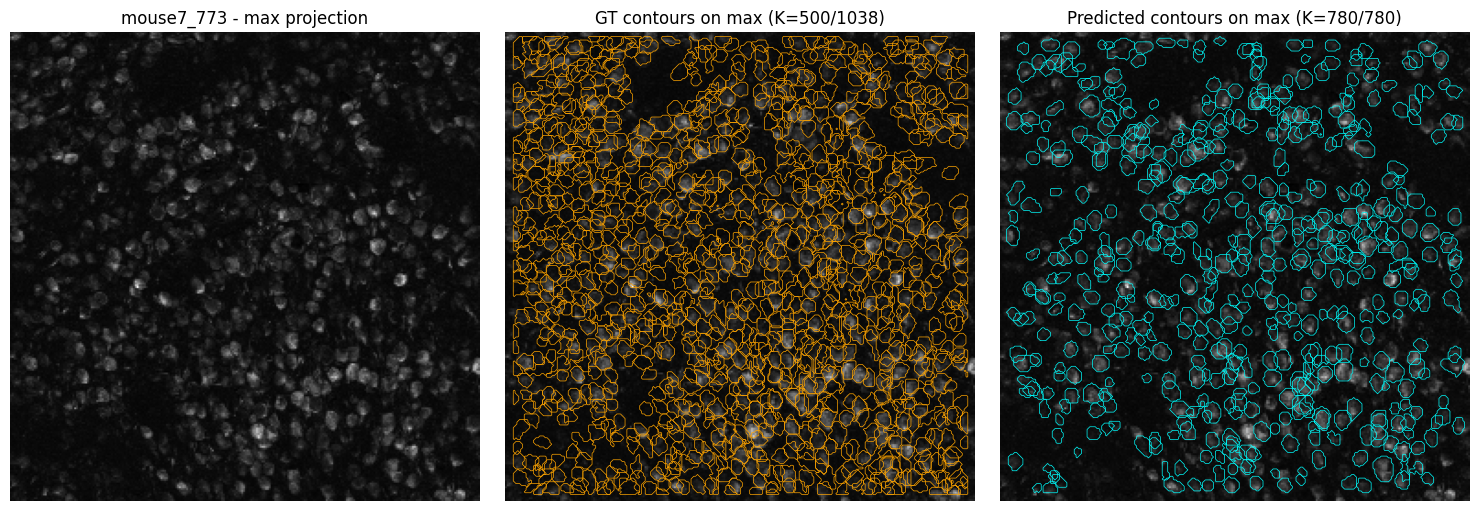

In [31]:
# --- Visualization alignment parameters ---
# Rotate GT (and Pred if needed) by 90-degree steps to match network_input orientation
GT_ROT_K = 1 # values: 0, 1, 2, 3 (counter-clockwise 90° steps)
GT_FLIPUD = False
GT_FLIPLR = False

PRED_ROT_K = 0
PRED_FLIPUD = False
PRED_FLIPLR = False

# --- Plot: 3 subplots in one row (max, GT-on-max, Pred-on-max) ---
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# 1) max projection only
axs[0].imshow(max_img, cmap='gray', origin='lower')
axs[0].set_title(f'{exp_id} - max projection')
axs[0].axis('off')

# 2) GT contours on the same max projection
axs[1].imshow(max_img, cmap='gray', origin='lower')
if n_gt > 0:
    Kgt = min(n_gt, 1038)
    for i in range(Kgt):
        if gt_masks[i].any():
            axs[1].contour(gt_masks[i].astype(float), levels=[0.5], colors='orange', linewidths=0.5, origin='lower')
axs[1].set_title(f'GT contours on max (K={min(n_gt,500)}/{n_gt})')
axs[1].axis('off')

# 3) Predicted contours on the same max projection
axs[2].imshow(max_img, cmap='gray', origin='lower')
if n_pred > 0:
    Kpred = min(n_pred, 500)
    for i in range(Kpred):
        if pred_masks[i].any():
            axs[2].contour(pred_masks[i].astype(float), levels=[0.5], colors='cyan', linewidths=0.5, origin='lower')
axs[2].set_title(f'Predicted contours on max (K={min(n_pred,1038)}/{n_pred})')
axs[2].axis('off')

plt.tight_layout(); plt.show()


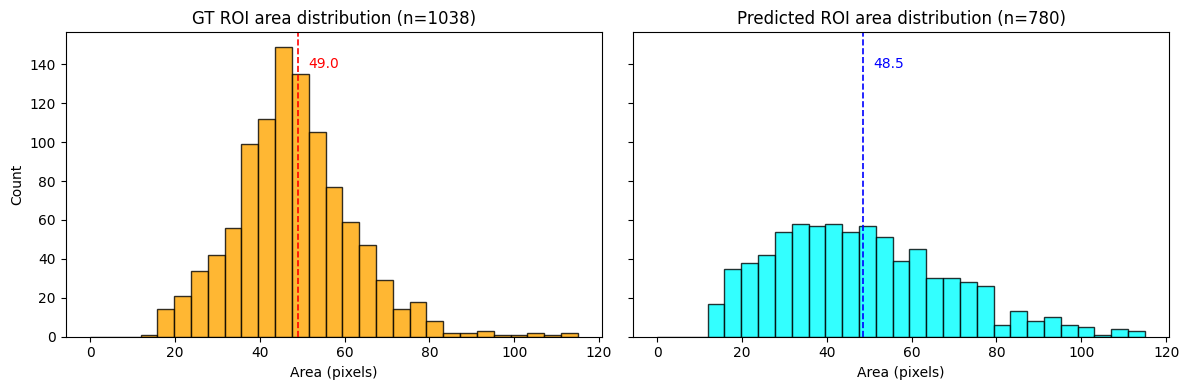

In [6]:
# --- ROI Area distributions (bar graphs + mean markers) ---
# Compute per-ROI areas in pixels
areas_gt = gt_masks.reshape(gt_masks.shape[0], -1).sum(axis=1) if gt_masks.size else np.array([])
areas_pr = pred_masks.reshape(pred_masks.shape[0], -1).sum(axis=1) if pred_masks.size else np.array([])

# Use common bins for fair comparison
all_areas = np.concatenate([areas_gt, areas_pr]) if areas_gt.size and areas_pr.size else (areas_gt if areas_gt.size else areas_pr)
if all_areas.size:
    hi = np.percentile(all_areas, 99.5)
    bins = np.linspace(0, hi, 30)
else:
    bins = 30

fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# GT bar graph + mean
ax[0].hist(areas_gt, bins=bins, color='orange', alpha=0.8, edgecolor='k')
ax[0].set_title(f'GT ROI area distribution (n={len(areas_gt)})')
ax[0].set_xlabel('Area (pixels)')
ax[0].set_ylabel('Count')
if areas_gt.size:
    mean_gt = float(np.mean(areas_gt))
    ax[0].axvline(mean_gt, color='red', linestyle='--', linewidth=1.2)
    ymax = ax[0].get_ylim()[1]
    xmin, xmax = ax[0].get_xlim()
    offset = 0.02 * (xmax - xmin)
    ax[0].text(min(mean_gt + offset, xmax), 0.92*ymax, f'{mean_gt:.1f}', color='red', ha='left', va='top')

# Pred bar graph + mean
ax[1].hist(areas_pr, bins=bins, color='cyan', alpha=0.8, edgecolor='k')
ax[1].set_title(f'Predicted ROI area distribution (n={len(areas_pr)})')
ax[1].set_xlabel('Area (pixels)')
if areas_pr.size:
    mean_pr = float(np.mean(areas_pr))
    ax[1].axvline(mean_pr, color='blue', linestyle='--', linewidth=1.2)
    ymax = ax[1].get_ylim()[1]
    xmin, xmax = ax[1].get_xlim()
    offset = 0.02 * (xmax - xmin)
    ax[1].text(min(mean_pr + offset, xmax), 0.92*ymax, f'{mean_pr:.1f}', color='blue', ha='left', va='top')

plt.tight_layout(); plt.show()


GT  mean circularity:  0.736 ± 0.139
Pred mean circularity: 0.811 ± 0.107


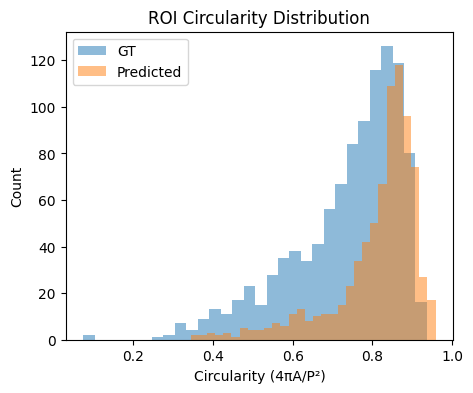

In [7]:
from skimage import measure

def compute_circularity(masks):
    """
    Compute circularity for each binary mask in the stack.
    Circularity = 4π * Area / (Perimeter²)
    Returns list of circularity values and perimeters.
    """
    circularities, perimeters, areas = [], [], []

    for i, mask in enumerate(masks):
        mask = mask.astype(bool)
        if not np.any(mask):
            circularities.append(np.nan)
            perimeters.append(0)
            areas.append(0)
            continue

        # Area = number of pixels
        area = np.sum(mask)
        areas.append(area)

        # Extract contours and measure perimeter in pixels
        contours = measure.find_contours(mask, 0.5)
        perim = 0.0
        for c in contours:
            diff = np.diff(c, axis=0)
            perim += np.sum(np.sqrt((diff ** 2).sum(axis=1)))
        perimeters.append(perim)

        # Circularity formula (avoid division by 0)
        circ = 4 * np.pi * area / (perim ** 2 + 1e-8)
        circularities.append(circ)

    return np.array(circularities), np.array(perimeters), np.array(areas)


# ---- Compute shape metrics for both GT and predictions ----
circ_gt, perim_gt, area_gt = compute_circularity(gt_masks)
circ_pr, perim_pr, area_pr = compute_circularity(pred_masks)

print(f"GT  mean circularity:  {np.nanmean(circ_gt):.3f} ± {np.nanstd(circ_gt):.3f}")
print(f"Pred mean circularity: {np.nanmean(circ_pr):.3f} ± {np.nanstd(circ_pr):.3f}")

# ---- Optional visualization ----
plt.figure(figsize=(5,4))
plt.hist(circ_gt, bins=30, alpha=0.5, label='GT')
plt.hist(circ_pr, bins=30, alpha=0.5, label='Predicted')
plt.xlabel('Circularity (4πA/P²)')
plt.ylabel('Count')
plt.legend()
plt.title('ROI Circularity Distribution')
plt.show()

# Each bar shows how many ROIs have a given circularity value. circularity= 4πA/P²: 1.0 means a perfect circle; lower values mean more elongated/irregular shapes.
# GT = 0.753, Pred = 0.841 mean the predicted ROIs are, on average, rounder and more uniform than the GT. The broader GT histogram indicates more shape 
# variety (irregular/merged cells).
# Any values slightly above 1 are due to pixel-grid/perimeter approximation; they’re harmless. If you want tighter estimates, compute perimeter with a sub‑pixel
#  method (e.g., skimage.measure.perimeter) or lightly smooth masks before measuring.

GT intra-set overlap (any pixel overlap): 96.1% of ROIs
Pred intra-set overlap (any pixel overlap): 84.6% of ROIs
GT intra-set overlap (IoU>0.1): 45.3%
Pred intra-set overlap (IoU>0.1): 59.2%
Fraction of GT neurons covered by Pred (IoU≥0.5): 38.6%
Fraction of Pred neurons supported by GT (IoU≥0.5): 51.5%


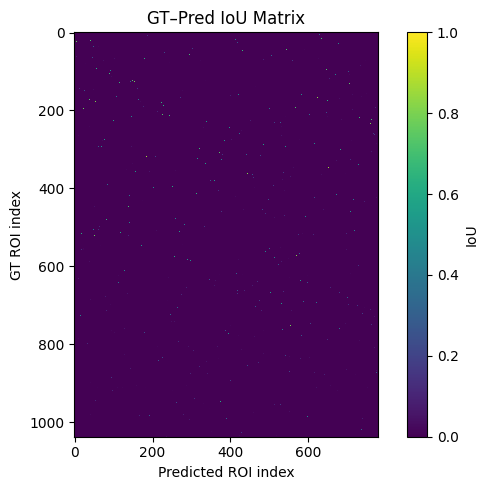

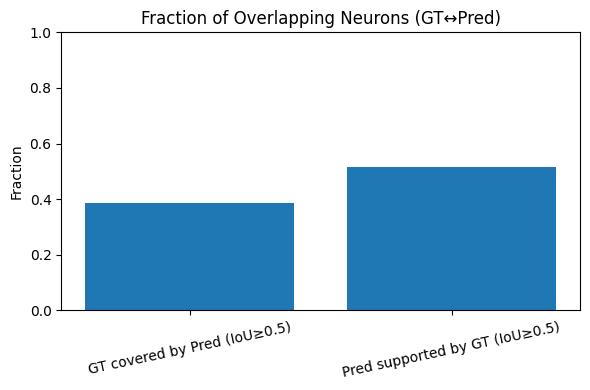

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# Overlap utilities
# ----------------------------
def pairwise_iou(stackA, stackB):
    """
    Memory-safe IoU:
    stackA: (Na, H, W) bool
    stackB: (Nb, H, W) bool
    returns IoU matrix (Na x Nb)
    """
    Na, H, W = stackA.shape
    Nb = stackB.shape[0]
    A = stackA.reshape(Na, -1).astype(np.uint8)
    B = stackB.reshape(Nb, -1).astype(np.uint8)

    # intersections via dot product
    inter = (A.astype(np.int32) @ B.astype(np.int32).T)  # (Na, Nb)
    areaA = A.sum(axis=1).astype(np.int32)[:, None]      # (Na, 1)
    areaB = B.sum(axis=1).astype(np.int32)[None, :]      # (1, Nb)
    union = areaA + areaB - inter
    iou = np.zeros((Na, Nb), dtype=np.float32)
    valid = union > 0
    iou[valid] = inter[valid] / union[valid]
    return iou

def within_set_overlap_fraction(stack, thresh=0.0, ratio='iou'):
    """
    Fraction of ROIs that overlap with at least one other ROI in the SAME set.
    Uses matmul for intersections (no 3-D arrays).
    """
    N = stack.shape[0]
    if N <= 1:
        return 0.0, np.zeros((N, N), dtype=np.float32)

    M = stack.reshape(N, -1).astype(np.uint8)
    areas = M.sum(axis=1).astype(np.int32)                  # (N,)
    inter = (M.astype(np.int32) @ M.astype(np.int32).T)     # (N, N)

    if ratio == 'iou' or ratio == 'union':
        union = areas[:, None] + areas[None, :] - inter     # (N, N)
        with np.errstate(divide='ignore', invalid='ignore'):
            mat = np.where(union > 0, inter / union, 0.0).astype(np.float32)
    elif ratio == 'min':
        amin = np.minimum(areas[:, None], areas[None, :])
        with np.errstate(divide='ignore', invalid='ignore'):
            mat = np.where(amin > 0, inter / amin, 0.0).astype(np.float32)
    else:
        raise ValueError("ratio must be 'iou', 'min', or 'union'.")

    np.fill_diagonal(mat, 0.0)  # ignore self
    has_overlap = (mat > thresh).any(axis=1)
    frac = has_overlap.mean() if N > 0 else 0.0
    return float(frac), mat


def between_sets_overlap_fractions(gt, pr, iou_thresh=0.5):
    """
    Fractions across sets:
      - fraction of GT ROIs that have at least one predicted ROI with IoU >= thresh
      - fraction of Pred ROIs that have at least one GT ROI with IoU >= thresh
      - also returns helpful summaries
    """
    if gt.shape[0] == 0 or pr.shape[0] == 0:
        return {
            "iou_matrix": np.zeros((gt.shape[0], pr.shape[0]), dtype=np.float32),
            "frac_gt_covered": 0.0,
            "frac_pred_supported": 0.0,
            "gt_max_iou": np.zeros(gt.shape[0], dtype=np.float32),
            "pr_max_iou": np.zeros(pr.shape[0], dtype=np.float32),
        }

    iou = pairwise_iou(gt, pr)
    gt_max = iou.max(axis=1) if iou.size else np.array([])
    pr_max = iou.max(axis=0) if iou.size else np.array([])
    frac_gt = (gt_max >= iou_thresh).mean() if gt_max.size else 0.0
    frac_pr = (pr_max >= iou_thresh).mean() if pr_max.size else 0.0

    return {
        "iou_matrix": iou,
        "frac_gt_covered": float(frac_gt),
        "frac_pred_supported": float(frac_pr),
        "gt_max_iou": gt_max,
        "pr_max_iou": pr_max,
    }

# ----------------------------
# Run the analyses
# ----------------------------
# Intra-set (collisions within GT and within Pred)
frac_gt_overlap, gt_overlap_mat = within_set_overlap_fraction(gt_masks, thresh=0.0, ratio='iou')
frac_pr_overlap, pr_overlap_mat = within_set_overlap_fraction(pred_masks, thresh=0.0, ratio='iou')

print(f"GT intra-set overlap (any pixel overlap): {100*frac_gt_overlap:.1f}% of ROIs")
print(f"Pred intra-set overlap (any pixel overlap): {100*frac_pr_overlap:.1f}% of ROIs")

# You can tighten the definition (e.g., IoU>0.1 to ignore tiny touches)
frac_gt_overlap_iou01, _ = within_set_overlap_fraction(gt_masks, thresh=0.1, ratio='iou')
frac_pr_overlap_iou01, _ = within_set_overlap_fraction(pred_masks, thresh=0.1, ratio='iou')
print(f"GT intra-set overlap (IoU>0.1): {100*frac_gt_overlap_iou01:.1f}%")
print(f"Pred intra-set overlap (IoU>0.1): {100*frac_pr_overlap_iou01:.1f}%")

# Inter-set (coverage between GT and Pred)
ov = between_sets_overlap_fractions(gt_masks, pred_masks, iou_thresh=0.5)
print(f"Fraction of GT neurons covered by Pred (IoU≥0.5): {100*ov['frac_gt_covered']:.1f}%")
print(f"Fraction of Pred neurons supported by GT (IoU≥0.5): {100*ov['frac_pred_supported']:.1f}%")

# ----------------------------
# Quick visuals (optional)
# ----------------------------
# IoU heatmap GT x Pred
if ov["iou_matrix"].size:
    plt.figure(figsize=(6,5))
    plt.imshow(ov["iou_matrix"], vmin=0, vmax=1, interpolation='nearest')
    plt.colorbar(label='IoU')
    plt.xlabel('Predicted ROI index')
    plt.ylabel('GT ROI index')
    plt.title('GT–Pred IoU Matrix')
    plt.tight_layout()
    plt.show()

# Bars summarizing "fraction overlapping neurons"
labels = ['GT covered by Pred (IoU≥0.5)', 'Pred supported by GT (IoU≥0.5)']
vals = [ov["frac_gt_covered"], ov["frac_pred_supported"]]
plt.figure(figsize=(6,4))
plt.bar(labels, vals)
plt.ylim(0,1)
plt.ylabel('Fraction')
plt.title('Fraction of Overlapping Neurons (GT↔Pred)')
plt.xticks(rotation=12)
plt.tight_layout()
plt.show()


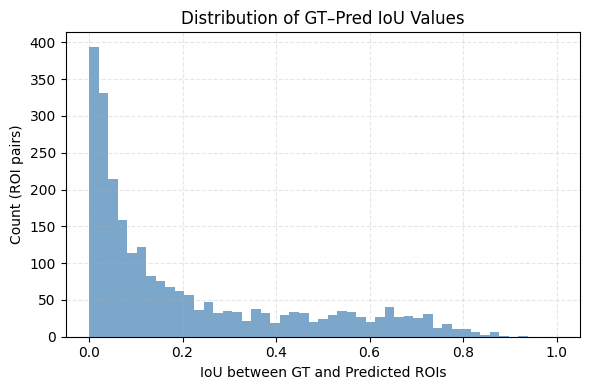

Mean IoU: 0.210 ± 0.227
Median IoU: 0.108
Fraction IoU ≥ 0.1: 52.0%
Fraction IoU ≥ 0.3: 27.4%
Fraction IoU ≥ 0.5: 16.1%


In [35]:
# --------------------------------------
# Distribution of GT–Pred IoU values
# --------------------------------------

iou_vals = ov["iou_matrix"].ravel()         # Flatten matrix to 1D
iou_vals = iou_vals[iou_vals > 0]           # Keep only positive overlaps

plt.figure(figsize=(6,4))
plt.hist(iou_vals, bins=np.linspace(0,1,50), color='steelblue', alpha=0.7)
plt.xlabel("IoU between GT and Predicted ROIs")
plt.ylabel("Count (ROI pairs)")
plt.title("Distribution of GT–Pred IoU Values")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Optional: print statistics
if iou_vals.size > 0:
    print(f"Mean IoU: {iou_vals.mean():.3f} ± {iou_vals.std():.3f}")
    print(f"Median IoU: {np.median(iou_vals):.3f}")
    print(f"Fraction IoU ≥ 0.1: {(iou_vals >= 0.1).mean()*100:.1f}%")
    print(f"Fraction IoU ≥ 0.3: {(iou_vals >= 0.3).mean()*100:.1f}%")
    print(f"Fraction IoU ≥ 0.5: {(iou_vals >= 0.5).mean()*100:.1f}%")
else:
    print("No overlapping pairs found.")


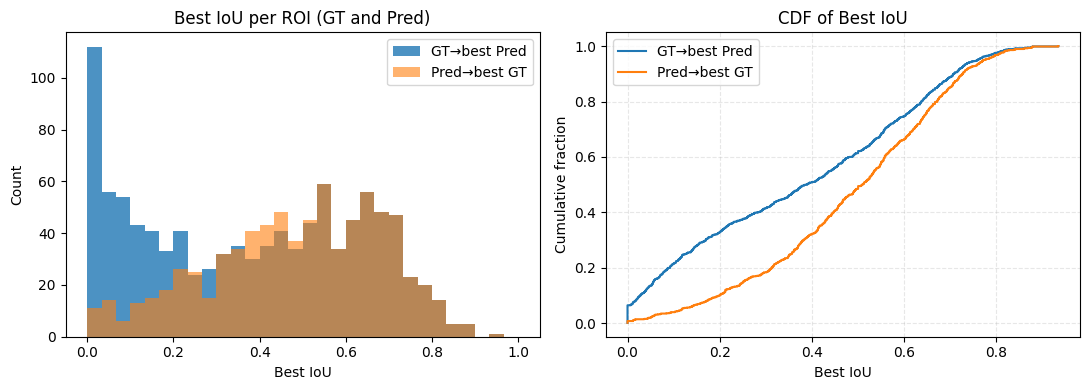

IoU≥0.1  GT covered:  78.6%   Pred supported:  96.0%
IoU≥0.3  GT covered:  58.6%   Pred supported:  81.7%
IoU≥0.5  GT covered:  38.6%   Pred supported:  51.5%


In [36]:
# ---------- Per-ROI best IoU histograms & CDFs ----------
gt_max = ov["gt_max_iou"]  # best Pred match for each GT ROI
pr_max = ov["pr_max_iou"]  # best GT match for each Pred ROI

bins = np.linspace(0, 1, 31)

plt.figure(figsize=(11,4))
plt.subplot(1,2,1)
plt.hist(gt_max, bins=bins, alpha=0.8, label='GT→best Pred', density=False)
plt.hist(pr_max, bins=bins, alpha=0.6, label='Pred→best GT', density=False)
plt.xlabel('Best IoU')
plt.ylabel('Count')
plt.title('Best IoU per ROI (GT and Pred)')
plt.legend()

plt.subplot(1,2,2)
for arr, lab in [(gt_max, 'GT→best Pred'), (pr_max, 'Pred→best GT')]:
    xs = np.sort(arr)
    ys = np.arange(1, xs.size+1) / xs.size if xs.size else np.array([])
    plt.step(xs, ys, where='post', label=lab)
plt.xlabel('Best IoU')
plt.ylabel('Cumulative fraction')
plt.title('CDF of Best IoU')
plt.grid(True, ls='--', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

for thr in [0.1, 0.3, 0.5]:
    cov_gt = (gt_max >= thr).mean() if gt_max.size else 0.0
    sup_pr = (pr_max >= thr).mean() if pr_max.size else 0.0
    print(f"IoU≥{thr:.1f}  GT covered: {100*cov_gt:5.1f}%   Pred supported: {100*sup_pr:5.1f}%")


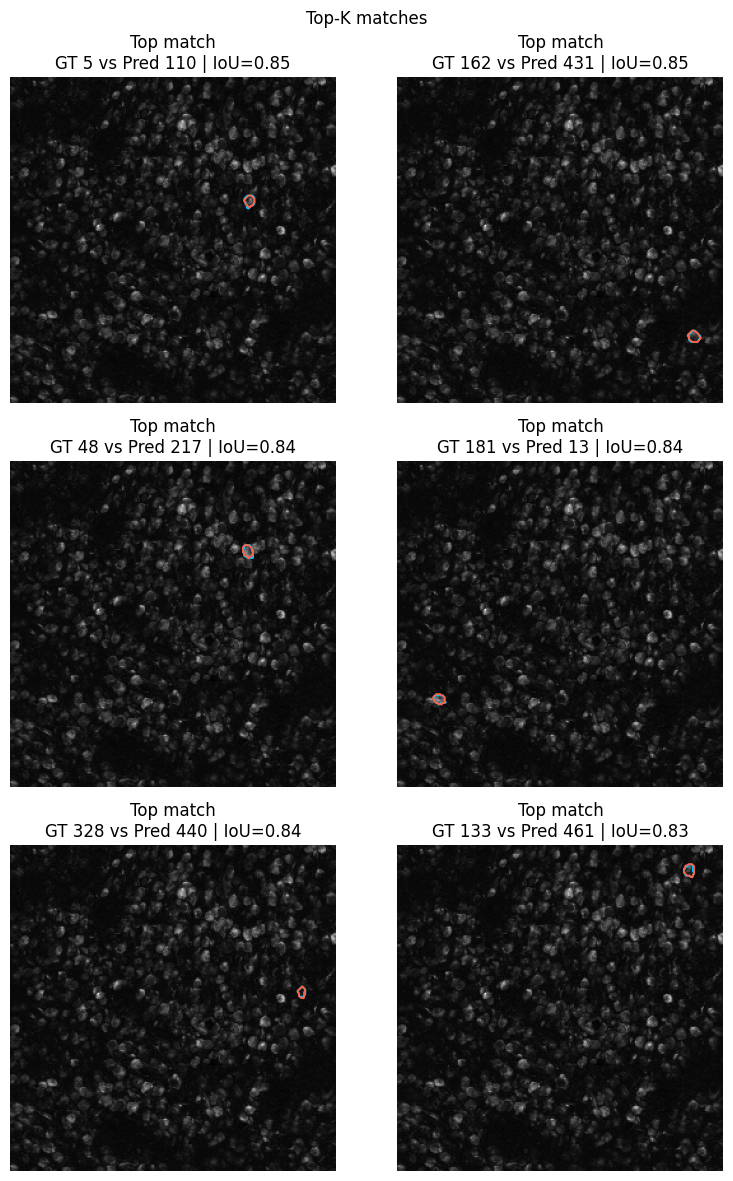

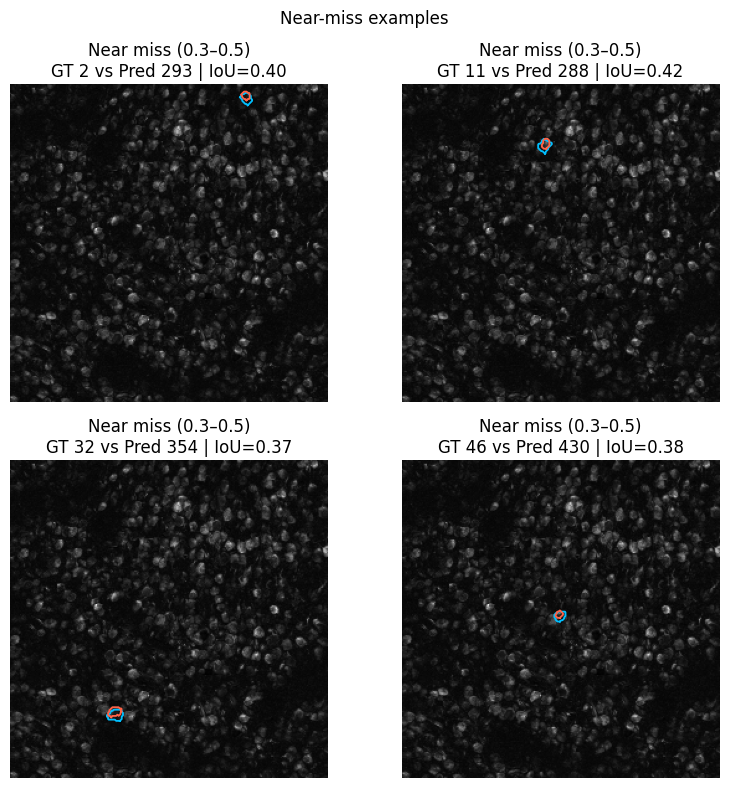

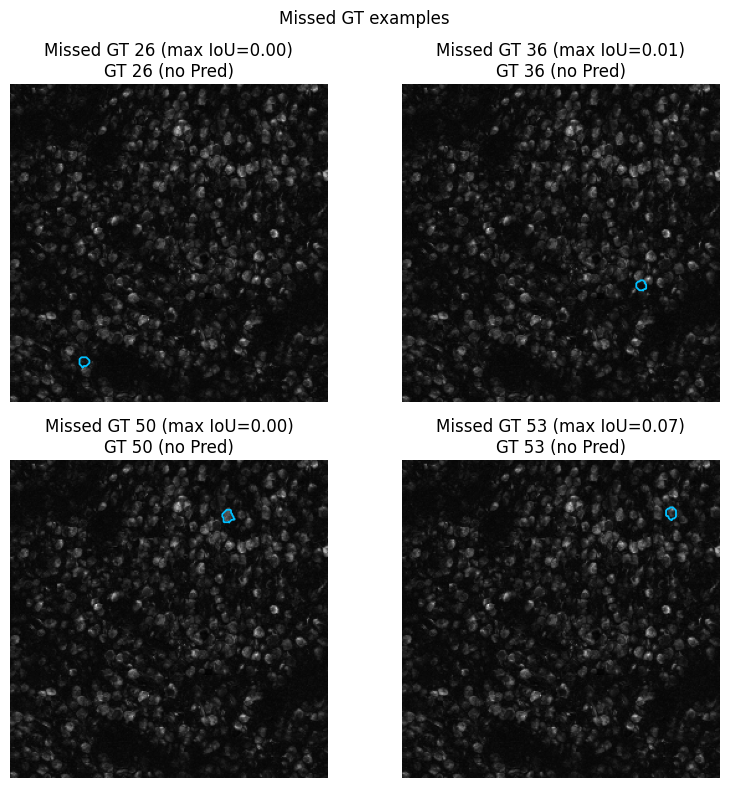

In [19]:
from skimage import measure


def draw_contours_on_image(img, masks, indices, color, lw=1.0, ax=None):
    H, W = img.shape
    ax = ax if ax is not None else plt.gca()
    for idx in indices:
        m = masks[idx].astype(bool)
        for c in measure.find_contours(m, 0.5):
            x, y = c[:,1], c[:,0]
            ax.plot(x, y, color=color, lw=lw)


def show_pair_overlay(ax, gt_idx, pr_idx=None, title=''):
    ax.imshow(max_img, cmap='gray', vmin=0, vmax=1)
    draw_contours_on_image(max_img, gt_masks, [gt_idx], color='deepskyblue', lw=1.3, ax=ax)
    if pr_idx is not None:
        draw_contours_on_image(max_img, pred_masks, [pr_idx], color='tomato', lw=1.3, ax=ax)
        iou_val = ov["iou_matrix"][gt_idx, pr_idx]
        ttl = f'{title}\nGT {gt_idx} vs Pred {pr_idx} | IoU={iou_val:.2f}'
    else:
        ttl = f'{title}\nGT {gt_idx} (no Pred)'
    ax.set_title(ttl)
    ax.axis('off')


def _grid_dims(n, max_rows=3):
    if n <= 0:
        return 1, 1
    ncols = int(np.ceil(n / max_rows))
    nrows = int(np.ceil(n / ncols))
    return nrows, ncols


def _plot_pairs_grid(pairs, suptitle):
    n = len(pairs)
    if n == 0:
        return
    nrows, ncols = _grid_dims(n, max_rows=3)
    fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows))
    axes = np.array(axes).reshape(-1)
    for ax, (g, p, t) in zip(axes, pairs):
        show_pair_overlay(ax, int(g), (int(p) if p is not None else None), title=t)
    for ax in axes[len(pairs):]:
        ax.axis('off')
    fig.suptitle(suptitle, y=0.98)
    plt.tight_layout()
    plt.show()


I = ov["iou_matrix"]
if I.size:
    # --- Top-K best matches ---
    K = 6
    flat = I.ravel()
    top_idx = np.argpartition(-flat, kth=min(K, flat.size-1))[:K]
    gt_top, pr_top = np.unravel_index(top_idx, I.shape)
    top_pairs = [(g, p, 'Top match') for g, p in zip(gt_top, pr_top)]
    _plot_pairs_grid(top_pairs, 'Top-K matches')

    # --- Near-miss examples: best IoU in [0.3, 0.5) ---
    g_best = I.max(axis=1)
    cand = np.where((g_best >= 0.30) & (g_best < 0.50))[0]
    near_pairs = []
    for g in cand[:4]:
        p = int(I[g].argmax())
        near_pairs.append((int(g), p, 'Near miss (0.3–0.5)'))
    _plot_pairs_grid(near_pairs, 'Near-miss examples')

    # --- Missed GT examples: best IoU < 0.1 ---
    missed = np.where(I.max(axis=1) < 0.10)[0]
    miss_pairs = [(int(g), None, f'Missed GT {int(g)} (max IoU={I[g].max():.2f})') for g in missed[:4]]
    _plot_pairs_grid(miss_pairs, 'Missed GT examples')


In [17]:
def pairwise_max_overlap(gt_masks, pred_masks):
    """
    Computes pairwise overlap between GT and Predicted masks using
    max(intersection/area_gt, intersection/area_pred).
    Returns:
        overlap_matrix: (N_gt x N_pred) float array in [0,1]
    """
    N_gt, H, W = gt_masks.shape
    N_pr = pred_masks.shape[0]
    A = gt_masks.reshape(N_gt, -1).astype(np.uint8)
    B = pred_masks.reshape(N_pr, -1).astype(np.uint8)

    # Intersection counts via matrix multiplication
    inter = (A.astype(np.int32) @ B.astype(np.int32).T)   # (N_gt, N_pr)

    area_gt = A.sum(axis=1).astype(np.int32)[:, None]     # (N_gt, 1)
    area_pr = B.sum(axis=1).astype(np.int32)[None, :]     # (1, N_pr)

    with np.errstate(divide='ignore', invalid='ignore'):
        frac1 = np.where(area_gt > 0, inter / area_gt, 0.0)
        frac2 = np.where(area_pr > 0, inter / area_pr, 0.0)
        overlap = np.maximum(frac1, frac2)

    return overlap


Mean max-overlap per GT: 0.513
Mean max-overlap per Pred: 0.775
Fraction of GT with overlap ≥0.5: 52.8%
Fraction of Pred with overlap ≥0.5: 86.1%


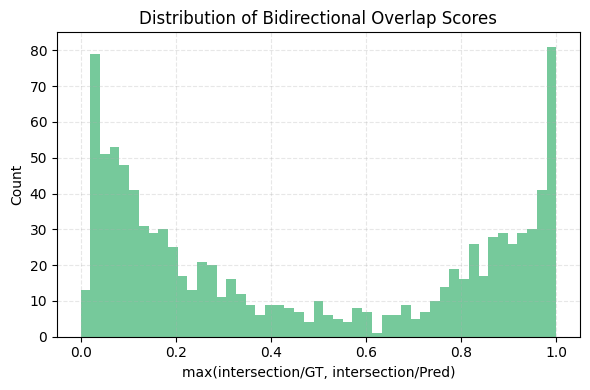

In [18]:
overlap = pairwise_max_overlap(gt_masks, pred_masks)

# For each GT mask: best overlap with any predicted mask
gt_best = overlap.max(axis=1)
pr_best = overlap.max(axis=0)

print(f"Mean max-overlap per GT: {gt_best.mean():.3f}")
print(f"Mean max-overlap per Pred: {pr_best.mean():.3f}")
print(f"Fraction of GT with overlap ≥0.5: {(gt_best>=0.5).mean()*100:.1f}%")
print(f"Fraction of Pred with overlap ≥0.5: {(pr_best>=0.5).mean()*100:.1f}%")

# Visualization of overlap distribution
plt.figure(figsize=(6,4))
plt.hist(overlap[overlap>0].ravel(), bins=np.linspace(0,1,50), color='mediumseagreen', alpha=0.7)
plt.xlabel('max(intersection/GT, intersection/Pred)')
plt.ylabel('Count')
plt.title('Distribution of Bidirectional Overlap Scores')
plt.grid(True, ls='--', alpha=0.3)
plt.tight_layout()
plt.show()


In [23]:
from scipy.optimize import linear_sum_assignment

def compute_f1_from_overlap(overlap_matrix, thr=0.5):
    """
    Computes TP/FP/FN and F1 based on the bidirectional overlap matrix.
    Matching is done via Hungarian assignment using overlap >= thr.
    """
    if overlap_matrix.size == 0:
        return dict(TP=0, FP=0, FN=0, precision=0.0, recall=0.0, f1=0.0)

    N_gt, N_pr = overlap_matrix.shape

    # cost matrix = 1 - overlap (we want to maximize overlap)
    cost = 1.0 - overlap_matrix
    cost[overlap_matrix < thr] = 1e6  # forbid low-overlap pairs

    # Hungarian matching (optimal one-to-one matches)
    row_ind, col_ind = linear_sum_assignment(cost)
    matched = overlap_matrix[row_ind, col_ind] >= thr
    TP = int(matched.sum())
    FP = N_pr - TP
    FN = N_gt - TP

    precision = TP / (TP + FP + 1e-8)
    recall    = TP / (TP + FN + 1e-8)
    f1        = 2 * precision * recall / (precision + recall + 1e-8)

    return dict(TP=TP, FP=FP, FN=FN, precision=precision, recall=recall, f1=f1)

# ---- Try for a few thresholds ----
for thr in [0.2, 0.3, 0.5, 0.7]:
    res = compute_f1_from_overlap(overlap, thr)
    print(f"Threshold ≥ {thr:.2f} | TP={res['TP']} FP={res['FP']} FN={res['FN']} "
          f"| P={res['precision']:.3f} R={res['recall']:.3f} F1={res['f1']:.3f}")


Threshold ≥ 0.20 | TP=418 FP=63 FN=339 | P=0.869 R=0.552 F1=0.675
Threshold ≥ 0.30 | TP=405 FP=76 FN=352 | P=0.842 R=0.535 F1=0.654
Threshold ≥ 0.50 | TP=388 FP=93 FN=369 | P=0.807 R=0.513 F1=0.627
Threshold ≥ 0.70 | TP=364 FP=117 FN=393 | P=0.757 R=0.481 F1=0.588
